# _De novo_ Reinforcement Learning with the Reinvent prior

This is a short demo to
- Set up a reinforcment learning run
- Carry out a reinforcment learning run
- Visualize the results with TensorBoard
- Extract the raw data from TensorBoard and how to work with it

# Reinvent事前学習によるデノボ強化学習

これは
- 強化学習のセットアップ
- 強化学習の実行
- TensorBoardで結果を可視化する
- TensorBoardから生データを取り出し、それをどのように扱うか。

In [1]:
import os
import shutil

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import reinvent
from reinvent.notebooks import load_tb_data, plot_scalars, get_image, create_mol_grid

%load_ext tensorboard

## Set up the REINVENT run

A work directory is defined and created anew (all previous data deleted if the directory already exsists).  The prior file is taken from the REINVENT repository and the agent is initially the same as the prior.  A TOML configuration is written out to file in the work directory.

## REINVENTランのセットアップ

作業ディレクトリが定義され、新たに作成される（ディレクトリがすでに存在する場合は、以前のデータはすべて削除される）。  先行ファイルはREINVENTリポジトリから取得され、エージェントは先行ファイルと同じ状態になります。  TOML 設定がワークディレクトリのファイルに書き出される。

In [2]:
wd = "/tmp/R4_notebooks_output"

### Delete existing working directory (!)

Skip this step if you have already carried out the RL run but wish to analyis the results further.

### 既存の作業ディレクトリを削除する。

すでにRLを実行したが、さらに結果を分析したい場合は、このステップをスキップしてください。

In [3]:
shutil.rmtree(wd, ignore_errors=True)
os.mkdir(wd)
os.chdir(wd)

### Global configuration parameters

Parameters global to the run:
- The run type: one of "scoring", "sampling", "transfer_learning", and "staged_learning"
- The device to run on: "cpu" or "cuda:0" where the number is the device index (needed for ROCm)
- The output directory for TensorBoard (optional)
- The configuration file in JSON format (optional)

### グローバル設定パラメータ

ランのグローバルパラメータ：
- 実行タイプ："scoring"、"sampling"、"transfer_learning"、"staged_learning "のいずれか。
- 実行するデバイス：「cpu "または "cuda:0"。数字はデバイスインデックス（ROCmに必要）。
- TensorBoardの出力ディレクトリ（オプション）
- JSON形式の設定ファイル（オプション）

In [4]:
global_parameters = """
run_type = "staged_learning"
device = "mps"
tb_logdir = "tb_stage1"
json_out_config = "_stage1.json"
"""

### Parameters

Here we specify the model files, the prefix for the output CSV summary file and the batch size for sampling and stochastic gradient descent (SGD).  The batch size is often given in 2^N but there is in now way required.  Typically batch sizes are betwen 50 and 150.  Batch size effects on SGD and so also the learning rate.  Some experimentation may be required to adjust this but keep in mind that, say, raising the total score as fast as possible is not necessarily the best choice as this may hamper exploration.

ここでは、モデルファイル、出力CSV要約ファイルの接頭辞、サンプリングと確率的勾配降下法（SGD）のバッチサイズを指定します。  バッチサイズは2^Nで指定されることが多いが、実際には必要ない。  通常、バッチサイズは50から150の間である。  バッチサイズはSGDに影響し、学習率にも影響する。  これを調整するためにいくつかの実験が必要かもしれないが、例えば、できるだけ速く総スコアを上げることは、探索を妨げる可能性があるため、必ずしも最良の選択ではないことに留意してほしい。

In [5]:
prior_filename = os.path.join(os.path.expanduser("~/git/REINVENT4"), "priors", "reinvent.prior")
agent_filename = prior_filename

parameters = f"""
[parameters]

prior_file = "{prior_filename}"
agent_file = "{agent_filename}"
summary_csv_prefix = "stage1"

batch_size = 100

use_checkpoint = false
"""

### Reinforcement Learning strategy

### 強化学習戦略

In [6]:
learning_strategy = """
[learning_strategy]

type = "dap"
sigma = 128
rate = 0.0001
"""

###  Stage setup

Here we only use a single stage. The aim of this stage is to create an agent which is highly likely to generate "drug-like" molecules (as per QED and Custom Alerts) with no stereocentres

The stage will terminate when a maximum number of 300 steps is reached.  Termination could occur earlier when the maximum score of 1.0 is exceeded but this is very unlikely to occur.  A checkpoint file is written out which can be used as the agent in a subsequent stage.

The scoring function is a weighted product of all the scoring components: QED and number of sterecentres.  The latter is used here to avoid stereocentres as they are not support by the Reinvent prior.  Zero stereocentres aids in downstream 3D task to avoid having to carry out stereocentre enumeration.  Custom alerts is a filter which filters out (scores as zero) all generated compounds which match one of the SMARTS patterns.  Number of sterecentres uses a transformation function to ensure the component score is between 0 and 1.


### ステージセットアップ

ここでは1つのステージのみを使用する。このステージの目的は、立体中心を持たない「薬物様」分子（QEDとCustom Alertsによる）を生成する可能性の高いエージェントを作成することである。

ステージは最大300ステップに達すると終了する。  最大スコア1.0を超えると終了が早まる可能性があるが、その可能性は非常に低い。  チェックポイントファイルが書き出され、後続ステージのエージェントとして使用できます。

採点関数は、すべての採点要素の加重積である：QEDとステレセントの数である。  ステレオセンターはReinventではサポートされないため、ここでは後者を使用します。  ステレオセンターをゼロにすることで、下流の3Dタスクでステレオセンターの列挙を行う必要がなくなります。  Custom alerts は、SMARTS パターンのいずれかに一致する生成化合物をすべてフィルタリング（ゼロスコア）するフィルターです。  Number of sterecentresは、コンポーネントスコアが0と1の間になるように変換関数を使用します。

In [7]:
stages = """
[[stage]]

max_score = 1.0
max_steps = 300

chkpt_file = 'stage1.chkpt'

scoring_function.type = "custom_product"

[stage.scoring]
type = "geometric_mean"

[[stage.scoring.component]]
[stage.scoring.component.custom_alerts]

[[stage.scoring.component.custom_alerts.endpoint]]
name = "Alerts"

params.smarts = [
    "[*;r8]",
    "[*;r9]",
    "[*;r10]",
    "[*;r11]",
    "[*;r12]",
    "[*;r13]",
    "[*;r14]",
    "[*;r15]",
    "[*;r16]",
    "[*;r17]",
    "[#8][#8]",
    "[#6;+]",
    "[#16][#16]",
    "[#7;!n][S;!$(S(=O)=O)]",
    "[#7;!n][#7;!n]",
    "C#C",
    "C(=[O,S])[O,S]",
    "[#7;!n][C;!$(C(=[O,N])[N,O])][#16;!s]",
    "[#7;!n][C;!$(C(=[O,N])[N,O])][#7;!n]",
    "[#7;!n][C;!$(C(=[O,N])[N,O])][#8;!o]",
    "[#8;!o][C;!$(C(=[O,N])[N,O])][#16;!s]",
    "[#8;!o][C;!$(C(=[O,N])[N,O])][#8;!o]",
    "[#16;!s][C;!$(C(=[O,N])[N,O])][#16;!s]"
]

[[stage.scoring.component]]
[stage.scoring.component.QED]

[[stage.scoring.component.QED.endpoint]]
name = "QED"
weight = 0.6


[[stage.scoring.component]]
[stage.scoring.component.NumAtomStereoCenters]

[[stage.scoring.component.NumAtomStereoCenters.endpoint]]
name = "Stereo"
weight = 0.4

transform.type = "left_step"
transform.low = 0
"""

In [8]:
config = global_parameters + parameters + learning_strategy + stages

toml_config_filename = "stage1.toml"

with open(toml_config_filename, "w") as tf:
    tf.write(config)

##  Start Reinforcement Learning

This run will take several minutes to finish and timings are provided at the end of the run.  After the run the TensorBoard output can be used to inspect the results of the run

## 強化学習の開始

この実行は終了するまでに数分かかり、タイミングは実行の最後に提供される。  実行後、TensorBoardの出力を使って実行結果を確認することができます。

In [9]:
%%time
!reinvent -l stage1.log $toml_config_filename

CPU times: user 1.1 s, sys: 309 ms, total: 1.41 s
Wall time: 3min 55s


### Inspect results with TensorBoard

TensorBoard needs to be started after REINVENT has finished.  Scatter plots of all scoring components are shown (raw and transformed) in the _SCALARS_ tab as well as loss and fractions of valid and duplicate (per batch) SMILES.  The _IMAGES_ tab shows the first sampled molecules for each recorded RL step labelled with the total score for the molecule.

The loss likehoods (negative log likelihoods, NLL) for the agent is expected to move away from the prior NLL and also have smaller NLLs than the prior.  This shows that the agent is increasingly producing molecules different from the prior, closer to the signal from the scoring function as requested.  For sample efficiency it is desirable to observed few duplicates and a high number of valid molecules.  Note that results are stochastic and will not be different in every run of RL, even with exactly the same configuration.

### TensorBoardで結果を検査する

TensorBoardは、REINVENTの終了後に起動する必要があります。 _SCALARS_ タブには、すべてのスコアリング成分の散布図（生と変換）が表示され、有効SMILESと重複SMILESの損失と割合も表示されます。 _IMAGES_ タブには、記録されたRLステップごとに最初にサンプリングされた分子が、その分子の合計スコアとともに表示されます。

エージェントの損失尤度（negative log likelihoods, NLL）は、事前NLLから遠ざかり、事前NLLよりも小さくなることが期待されます。  これは、エージェントが事前とは異なる分子を生成し、要求されたスコアリング関数のシグナルに近づいていることを示しています。  サンプルの効率化のためには、重複が少なく、有効な分子の数が多いことが望ましい。  結果は確率的であり、全く同じコンフィギュレーションであっても、RLを実行するたびに異なるとは限らないことに注意。

In [10]:
%tensorboard --bind_all --logdir $wd/tb_stage1_0

## Extract data from TensorBoard

TensorBoard data can be directy extracted as shown in this section.

### Load the TB data

## TensorBoardからデータを取り出す

TensorBoardのデータは、このセクションで示すように直接抽出することができる。

### TB データをロードする

In [11]:
ea = load_tb_data(wd)

### Plot all scalars

All scalar values (except the raw components) are plotted here.  The data is also return as a Pandas dataframe and can so be conveniently used for further analysis or storing to a file.

### すべてのスカラーをプロットする

すべてのスカラー値（生成分を除く）がここにプロットされる。  データは Pandas dataframe としても返されるので、さらなる分析やファイルへの保存に便利に利用できる。

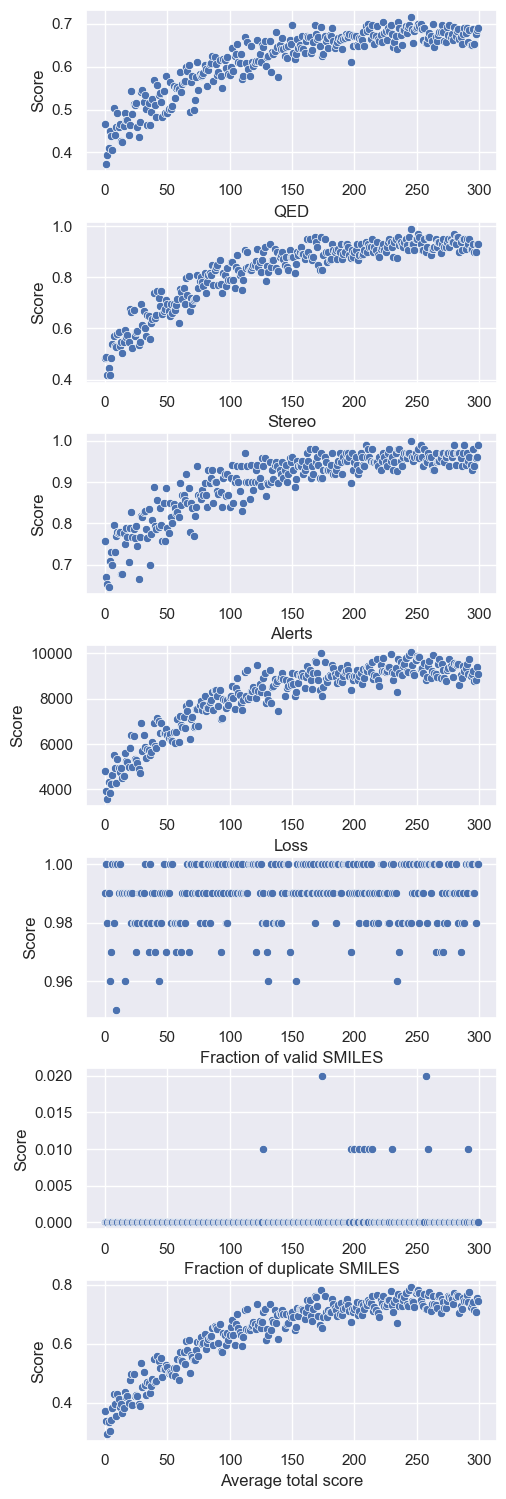

,QED,Stereo,Alerts,Loss,Fraction of valid SMILES,Fraction of duplicate SMILES,Average total score
0,0.466980,0.484848,0.757576,4822.027344,0.99,0.0,0.372933
1,0.374182,0.490000,0.670000,3937.641846,1.00,0.0,0.335925
2,0.393293,0.418367,0.653061,3592.589844,0.98,0.0,0.293986
3,0.410908,0.444444,0.646465,4343.664062,0.99,0.0,0.335703
4,0.449224,0.416667,0.708333,3861.627197,0.96,0.0,0.302032
...,...,...,...,...,...,...,...
295,0.687922,0.929293,0.979798,9197.197266,0.99,0.0,0.741716
296,0.653623,0.898990,0.939394,8775.838867,0.99,0.0,0.712591
297,0.675149,0.897959,0.959184,8805.250977,0.98,0.0,0.707021
298,0.684183,0.930000,0.960000,9404.148438,1.00,0.0,0.756227


In [12]:
df = plot_scalars(ea)

df

### Display an image from TB

Shows (only) the last image from TB.  The image depicts the first 30 molecules generated in the very last step of RL:

### TB から画像を表示する

TBからの最後の画像を（のみ）表示する。  この画像は、RLの最後のステップで生成された最初の30個の分子を示している：

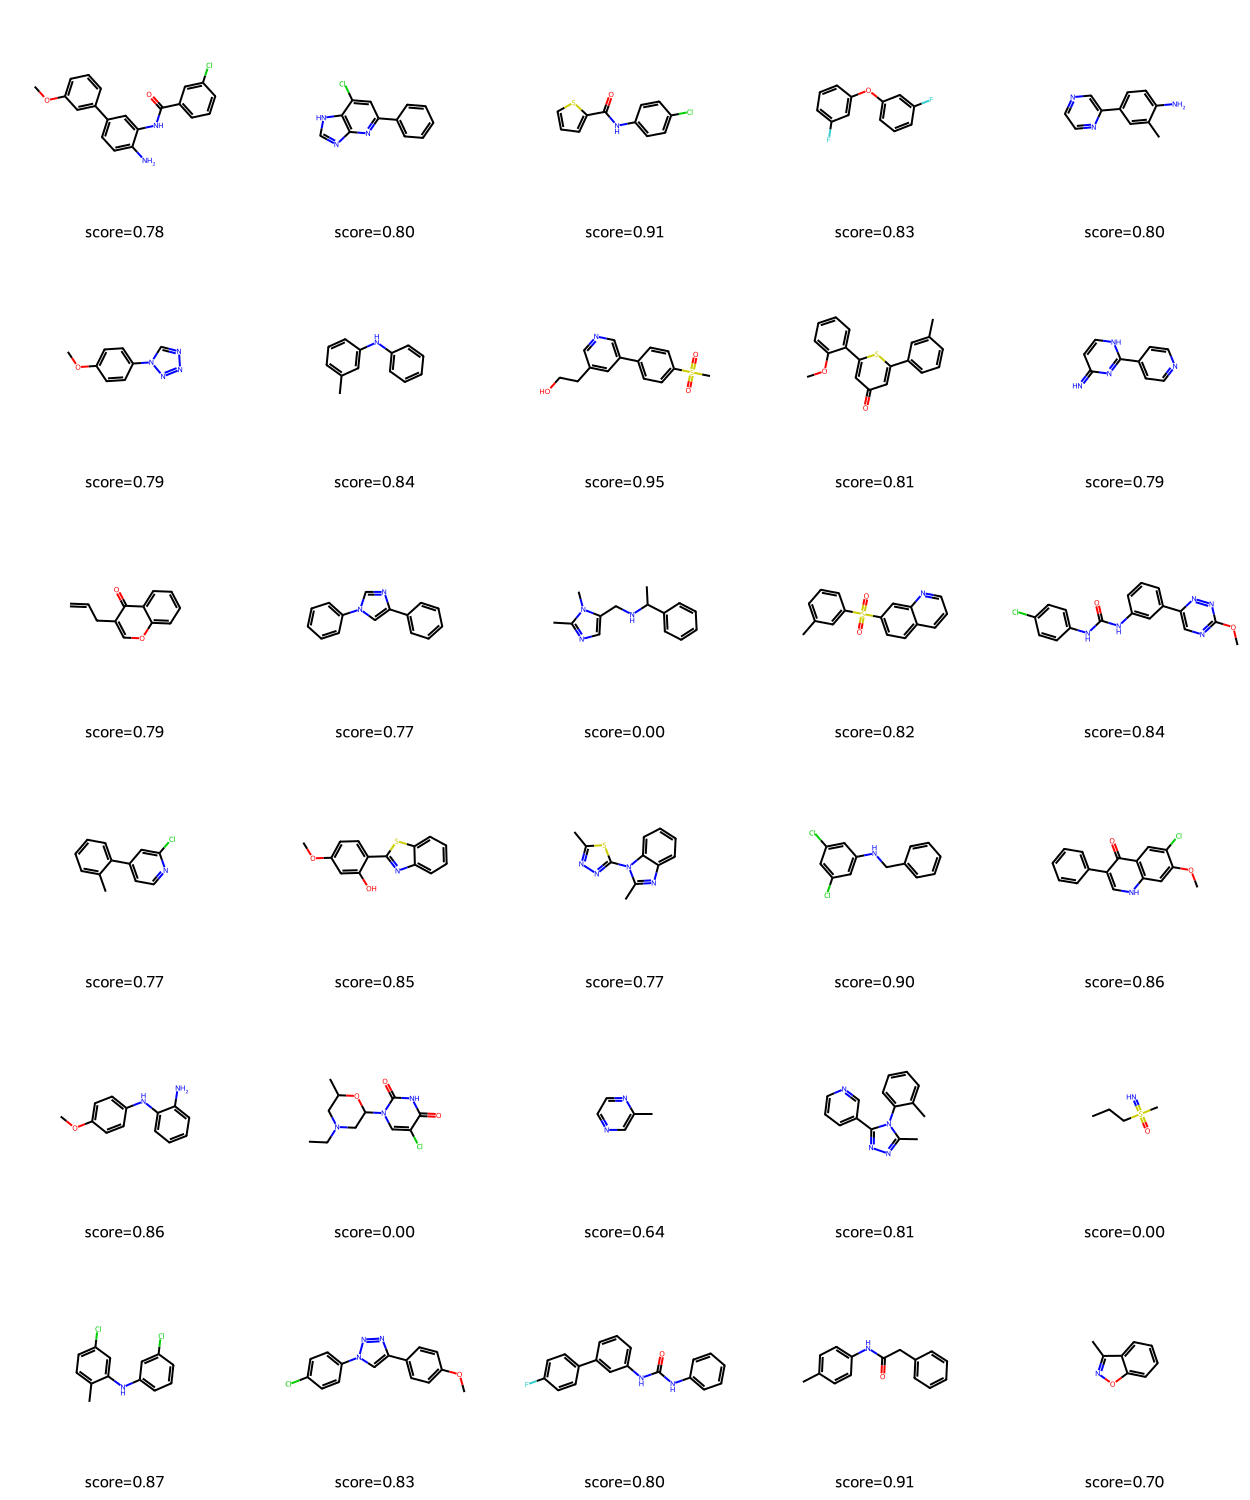

In [13]:
img = get_image(ea)
display(img)

## Extract data from the CSV file

The CSV file is generated during the RL run in real time i.e. as soon as the data is available it is written to file. So even if the RL job crashes in the middle of the run some partial data will be available.  The TensorBoard data is a subset of the data in the CSV file.  The CSV file contains in addition all SMILES strings, their state (0=invalid, 1=valid, 2=batch duplicate), the scaffold if a diversity filter has been used.

## CSV ファイルからデータを取り出す

CSVファイルはRLの実行中にリアルタイムで生成されます。つまり、データが利用可能になるとすぐにファイルに書き込まれます。そのため、RLジョブが実行の途中でクラッシュしても、一部のデータは利用可能です。  TensorBoardのデータは、CSVファイルのデータのサブセットです。  CSVファイルには、すべてのSMILES文字列、その状態（0=無効、1=有効、2=バッチ重複）、多様性フィルターが使用された場合の足場が含まれます。

In [14]:
csv_file = os.path.join(wd, "stage1_1.csv")
df = pd.read_csv(csv_file)
df

,Agent,Prior,Target,Score,SMILES,SMILES_state,QED,QED (raw),Stereo,Stereo (raw),Alerts,Alerts (raw),step
0,19.4013,19.4013,89.1117,0.847758,O=C(Cc1ccccc1)N=c1cc(-c2ccccc2)[nH][nH]1,1,0.759369,0.7594,1.0,0.0,1.0,1.0,1
1,19.5915,19.5915,81.9755,0.793493,Cc1cc(N2CCCCC2)n2nc(C)c(-c3ccc(Cl)cc3)c2n1,1,0.680098,0.6801,1.0,0.0,1.0,1.0,1
2,26.3768,26.3768,88.8408,0.900137,CCCCn1c(C)nc(N=Cc2cccs2)c1O,1,0.839166,0.8392,1.0,0.0,1.0,1.0,1
3,31.3292,31.3292,41.5732,0.569550,COc1cccc(C=CC(=O)Nc2ccc(S(=O)(=O)N=c3[nH]c(Cl)...,1,0.391339,0.3913,1.0,0.0,1.0,1.0,1
4,23.3695,23.3695,-23.3695,0.000000,Cc1nonc1CN1CCCC2(C1)CN(C)C(=O)O2,1,0.000000,0.0000,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,10.2478,16.1808,93.1950,0.854498,c1ccc(CNc2ccccc2)cc1,1,0.769459,0.7695,1.0,0.0,1.0,1.0,300
29996,17.2614,20.9386,102.9854,0.968156,O=S(=O)(Nc1cccnc1)c1ccc(Br)cc1,1,0.947492,0.9475,1.0,0.0,1.0,1.0,300
29997,20.7717,26.1586,75.6075,0.795048,Cc1cnccc1-n1cc(-c2ccccc2)cn1,1,0.682321,0.6823,1.0,0.0,1.0,1.0,300
29998,19.0195,25.4826,86.2010,0.872529,O=C(Nc1ccccc1-c1ccccc1)c1cccnn1,1,0.796709,0.7967,1.0,0.0,1.0,1.0,300


### Sample efficiency

Count the number of total invalid and duplcate SMILES and compare to the total number of generated SMILES.

### サンプル効率

無効なSMILESと重複したSMILESの総数を数え、生成されたSMILESの総数と比較する。

In [15]:
total_smilies = len(df)

invalids = df[df["SMILES_state"] == 0]
total_invalid_smilies = len(invalids)

duplicates = df[df["SMILES_state"] == 2]
total_batch_duplicate_smilies = len(duplicates)

all_duplicates = df[df.duplicated(subset=["SMILES"])]
total_duplicate_smilies = len(all_duplicates)

print(
    f"Total number of SMILES generated: {total_smilies}\n"
    f"Total number of invalid SMILES generated: {total_invalid_smilies}\n"
    f"Total number of batcg duplicate SMILES generated: {total_batch_duplicate_smilies}\n"
    f"Total number of duplicate SMILES generated: {total_duplicate_smilies}"
)

Total number of SMILES generated: 30000
Total number of invalid SMILES generated: 303
Total number of batcg duplicate SMILES generated: 14
Total number of duplicate SMILES generated: 1233


### Display all generated duplicates

### 生成された重複をすべて表示する

In [16]:
mol_view = create_mol_grid(all_duplicates)
display(mol_view)

MolGridWidget()

### Display the molecules from the last step

### 最後のステップの分子を表示する

In [17]:
last = df[df["step"] == max(df["step"])]
mol_view = create_mol_grid(last)
display(mol_view)

MolGridWidget()

### Plot the NLLs

The "Target" is the "augmented NLL".

### NLLのプロット

Target "は "augmented NLL "である。

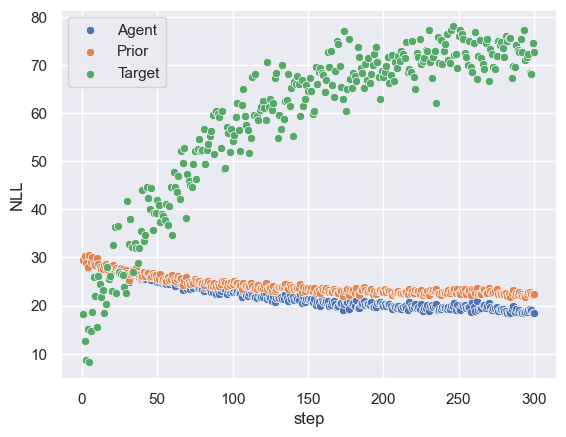

In [18]:
grouped_df = df.groupby("step")

for label in "Agent", "Prior", "Target":
    means = grouped_df.aggregate({label: "mean"})
    X = list(means.index.values)
    sns.scatterplot(means, x=X, y=label, label=label)

plt.xlabel("step")
plt.ylabel("NLL")
plt.show()